In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## Load the file

In [64]:
df_rd = pd.read_csv('roads_transposed.csv')

In [65]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance # in kilometers

In [66]:
def calc_lrp_distance(df):
    # get the lrp before
    df_lrp_before = df.shift(1)

    # calculate the haversine distance
    lrp_distance = df.apply(lambda row: haversine(row['lat'], 
                                                row['lon'], df_lrp_before.loc[row.name, 'lat'], 
                                                df_lrp_before.loc[row.name, 'lon']), axis=1)
    #get a df with road info of each lrp and its distance 
    distance_type = pd.DataFrame({'distance': lrp_distance, 'lrp': df['lrp'],'road':df['road']})	

    distance_type

    return lrp_distance, distance_type

In [67]:
def get_lrp_offroad(lrp_distance, quantile_value):
    # set threshold
    threshold = lrp_distance.quantile(quantile_value)
    #print(threshold)

    # both edges before and after the lrp are >>>
    lrp_offroad = lrp_distance.loc[(lrp_distance > threshold) & (lrp_distance.shift(-1) > threshold)]

    return lrp_offroad

In [68]:
def fix_offroad_lrp(df, lrp_offroad):
    # make sure not to overwrite the original df -> result in an annoying warning
    #df_copy = df.copy()
    
    # lat = 1/2 x (lat before + lat after)
    df.loc[lrp_offroad.index, "lat"] = 0.5 * (df.shift(1).loc[lrp_offroad.index, "lat"] + df.shift(-1).loc[lrp_offroad.index, "lat"])
    # lon = 1/2 x (lon before + lon after)
    df.loc[lrp_offroad.index, "lon"] = 0.5 *  (df.shift(1).loc[lrp_offroad.index, "lon"] + df.shift(-1).loc[lrp_offroad.index, "lon"])

    return df

In [69]:
def process_offroad_lrp(df):

    lrp_distance, dataframe = calc_lrp_distance(df)
    lrp_offroad = get_lrp_offroad(lrp_distance,0.8)
    fixed_df = fix_offroad_lrp(df, lrp_offroad)

    return fixed_df

In [70]:
def process_by_road(df, processing_function):
    # Group by 'road' column and apply the process_offroad_lrp function to each group
    processed_groups = df.groupby('road').apply(processing_function)
    
    # Reset the index to combine the groups back together
    processed_df = processed_groups.reset_index(drop=True)
    
    return processed_df

In [71]:
def plot_road_big(df):
    plt.figure(figsize=(16, 12))
    plt.scatter(df['lon'], df['lat'], color='y', alpha=0.7,
                label='lrp')
    plt.plot(df['lon'], df['lat'], color='k', alpha=1, linewidth=1,
            label='road')
        
    # Annotate each point with the 'lrp' label
    #for i, row in df.iterrows():
     #   plt.annotate(row['lrp'], (row['lon'], row['lat']), textcoords="offset points", xytext=(0, 5), ha='center')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Line Plot')
    plt.legend()
    plt

    plt.show()

## First attempt. 

First we plot raw data

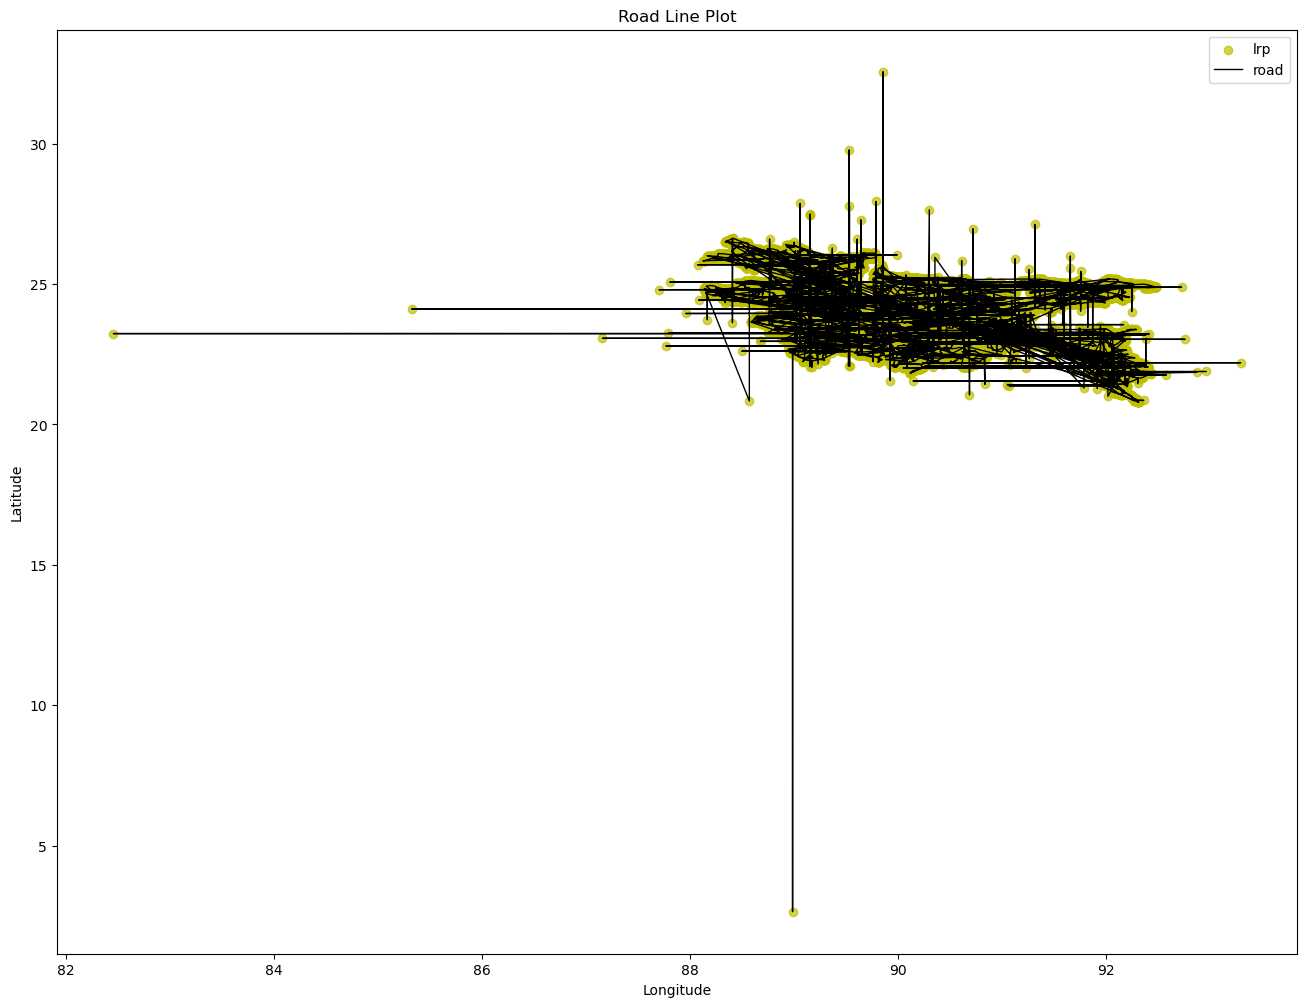

In [72]:
plot_road_big(df_rd)

In [73]:
df_rd1 = process_by_road(df_rd, process_offroad_lrp)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17324\3532550925.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_groups = df.groupby('road').apply(processing_function)


### Plotting data after first iteration: Significant improvement!!

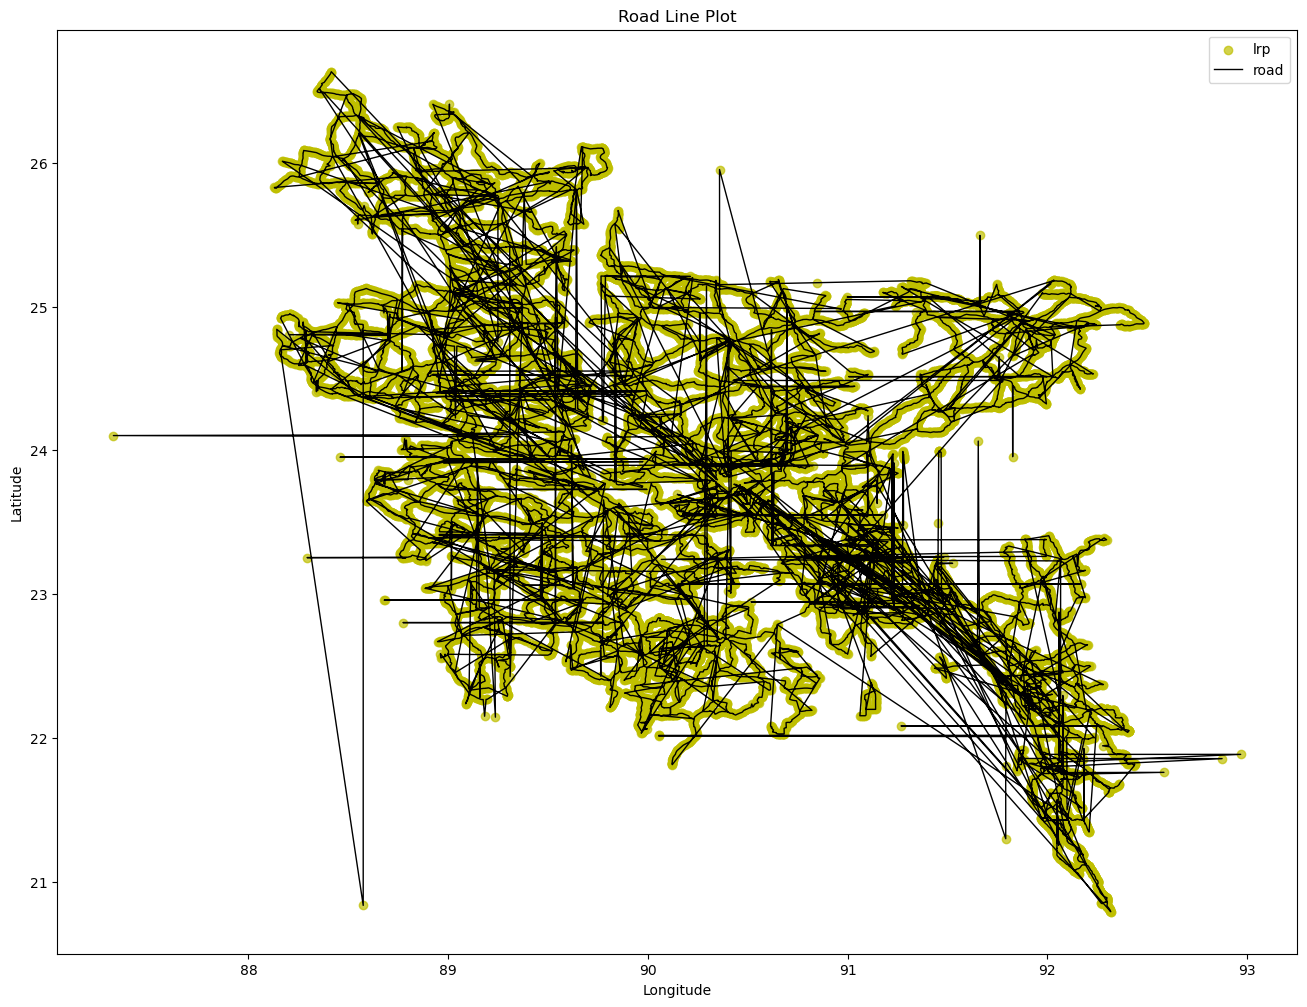

In [74]:
plot_road_big(df_rd1)

## Second iteration: quantile 0.99


In [75]:
def process_offroad_lrp2(df):

    lrp_distance = calc_lrp_distance(df)
    lrp_offroad = get_lrp_offroad(lrp_distance, 0.9)
    fixed_df = fix_offroad_lrp(df, lrp_offroad)

    return fixed_df

In [76]:
df_rd2 = process_by_road(df_rd1, process_offroad_lrp)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17324\3532550925.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_groups = df.groupby('road').apply(processing_function)


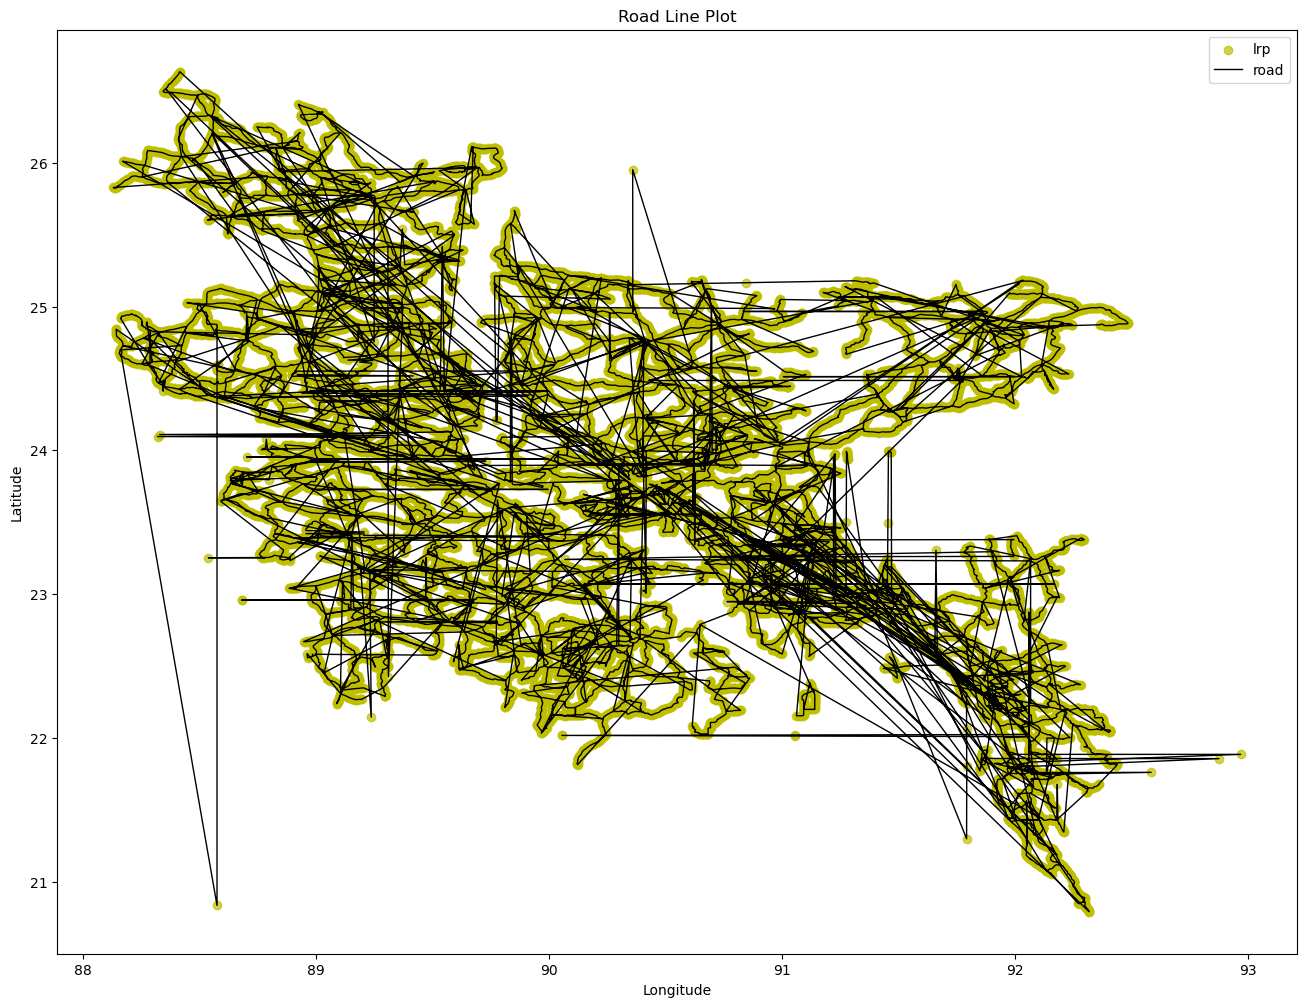

In [77]:
plot_road_big(df_rd2)

## Third iteration: consecutive points